In [13]:
# ref: https://github.com/ML-KULeuven/socceraction/blob/master/public-notebooks/1-load-and-convert-statsbomb-data.ipynb
import os
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")

In [ ]:
from socceraction.data.statsbomb import StatsBombLoader
SBL = StatsBombLoader()

## SPADLでゴールを描画

In [15]:
import socceraction.spadl as spadl

df_events = SBL.events(game_id=7548)
df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=781)

In [16]:
df_actions = (
  spadl
  .add_names(df_actions)  # add actiontype and result names
  .merge(SBL.teams(game_id=7548), how='left')  # add team names
  .merge(SBL.players(game_id=7548), how='left')  # add player names
)

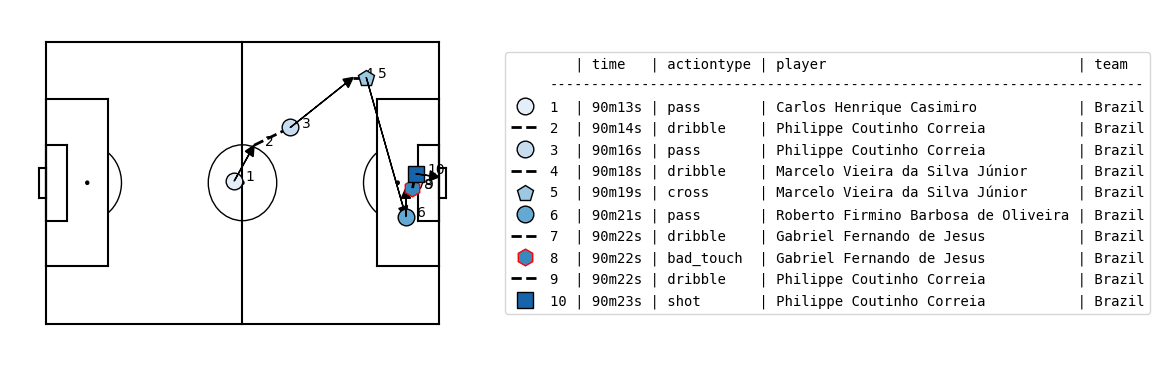

In [17]:
import matplotsoccer

shot = 2052 # コウチーニョの先制ゴール
a = df_actions[shot-9:shot+1].copy()

# skip "Print the game date and timestamp of the goal"

def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "type_name", "player_name", "team_name"]]

ax = matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False,
    figsize=6
)

## (try) Atomic-SPADLでゴールを描画

In [18]:
import socceraction.atomic.spadl as atomicspadl
df_atomic_actions = atomicspadl.convert_to_atomic(df_actions)

In [19]:
df_atomic_actions = (
  atomicspadl
  .add_names(df_atomic_actions)  # add actiontype and result names
  .merge(SBL.teams(game_id=7548), how='left')  # add team names
  .merge(SBL.players(game_id=7548), how='left')  # add player names
)

In [35]:
# ゴールを抽出
df_atomic_actions[(df_atomic_actions['type_name'] == 'goal')]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,team_name,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
3052,7548,9b36fcef-3875-48e8-8299-3cfc0fa1d509,3052,2,2723.0,781,3501.0,105.0,35.377215,0.0,0.0,27,5,goal,foot_right,Brazil,Philippe Coutinho Correia,Philippe Coutinho,11,True,15,Left Center Midfield,99
3267,7548,b7728f99-998f-46c8-8ea3-0595ba54eeb2,3267,2,3105.0,781,4320.0,105.0,37.356962,0.0,0.0,27,4,goal,foot_left,Brazil,Neymar da Silva Santos Junior,Neymar,10,True,21,Left Wing,99


In [48]:
atomic_shot = 3052 # コウチーニョの先制ゴール
atomic_a = df_atomic_actions[atomic_shot-14:atomic_shot+1].copy()

In [49]:
set(a.columns) - set(atomic_a.columns)

{'end_x',
 'end_y',
 'nice_time',
 'result_id',
 'result_name',
 'start_x',
 'start_y'}

In [50]:
set(atomic_a.columns) - set(a.columns)

{'dx', 'dy', 'x', 'y'}

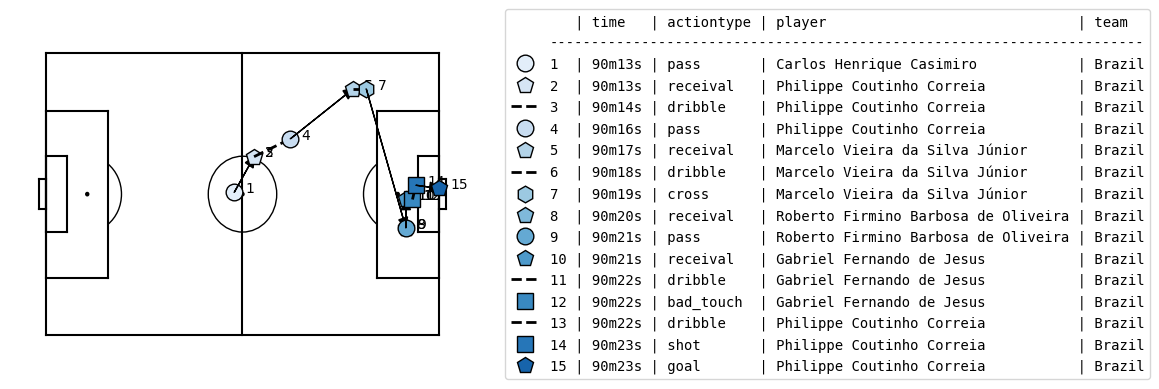

In [74]:
# skip "Print the game date and timestamp of the goal"

def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

atomic_a["nice_time"] = atomic_a.apply(nice_time, axis=1)
labels = atomic_a[["nice_time", "type_name", "player_name", "team_name"]]

ax = matplotsoccer.actions(
    location=pd.concat([atomic_a["x"], atomic_a["y"], atomic_a["x"]+atomic_a["dx"], atomic_a["y"]+atomic_a["dy"]], axis=1, ignore_index=True),
    action_type=atomic_a.type_name,
    team= atomic_a.team_name,
#     result= atomic_a.result_name == "success",
    label=labels,
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False,
    figsize=6
)